# Graph-Based Analysis of Neuronal Trees

A [graph](https://en.wikipedia.org/wiki/Graph_theory) is a collection of nodes (or vertices) connected by edges. In the context of neuron morphology analysis, a particularly useful construct is the [rooted tree](https://en.wikipedia.org/wiki/Tree_(graph_theory)#Rooted_tree).
To implement these data structures, we use [NetworkX](https://networkx.org/): a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.
It allows representing neuron morphologies (or collections of morphologies) as graphs, providing a convenient data structure for analysis of various morphological properties including branch lengths, number of terminals, shortest paths, etc.
To model synaptic connections, graph nodes can represent entire neurons with the edges connecting different neurons as synapses.
In this notebook, we will only analyze the structure of individual neurons, but the reader is encouraged to think about how these concepts apply more broadly to connectomics.

## Loading data into NetworkX

First, we define a function to parse the JSON files into a graph object. We use a directed graph with nodes representing the XYZ coordinates of the annotations, with edge weights given by the euclidean distance between adjacent nodes, which allows us to model the cell's 3-dimensional structure.

In [1]:
%matplotlib inline

import os
import json

import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

def euclidean_distance(node1, node2):
    """
    Calculate the Euclidean distance between two nodes.

    Parameters:
    node1, node2 (dict): Nodes with 'pos' key containing x, y, z coordinates.

    Returns:
    float: Euclidean distance between node1 and node2.
    """
    pos1 = np.array(node1['pos'])
    pos2 = np.array(node2['pos'])
    return np.linalg.norm(pos1 - pos2)

def add_node_to_graph(graph, node):
    """
    Add a node with attributes to the graph.

    Parameters:
    graph (nx.DiGraph): The graph to which the node will be added.
    node (dict): Node data containing sampleNumber, pos, radius, structure_id, and allen_id.
    """
    graph.add_node(
        node['sampleNumber'], 
        pos=(node['x'], node['y'], node['z']), 
        radius=node['radius'], 
        structure_id=node['structureIdentifier'],
        allen_id=node['allenId']
    )

def add_edge_to_graph(graph, parent, child):
    """
    Add an edge between parent and child nodes in the graph, with weight as Euclidean distance.

    Parameters:
    graph (nx.DiGraph): The graph to which the edge will be added.
    parent, child (int): The sampleNumbers of the parent and child nodes.
    """
    graph.add_edge(
        parent, 
        child, 
        weight=euclidean_distance(
            graph.nodes()[parent],
            graph.nodes()[child]
        )
    )

def json_to_digraph(file_path):
    """
    Load a neuronal reconstruction from a JSON file into a NetworkX graph.

    The JSON file contains neuronal data with additional brain region information for each node.
    The graph will be a simple, directed, rooted tree with no cycles or nodes with more than one parent.

    Parameters:
    file_path (str): Path to the JSON file containing neuronal reconstruction data.

    Returns:
    nx.DiGraph: A directed graph representing the neuronal tree.
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
    except IOError as e:
        print(f"Error opening file: {e}")
        return None

    axon_graph, dendrite_graph = nx.DiGraph(), nx.DiGraph()

    for structure, graph in [('dendrite', dendrite_graph), ('axon', axon_graph)]:
        for node in sorted(data['neuron'][structure], key=lambda x: x['sampleNumber']):
            add_node_to_graph(graph, node)
            if node['parentNumber'] != -1:
                add_edge_to_graph(graph, node['parentNumber'], node['sampleNumber'])

    axon_graph.remove_node(1)  # Remove duplicate soma node from axon graph

    # Merge graphs and rename nodes to avoid key collisions
    joined_graph = nx.union(dendrite_graph, axon_graph, rename=("D", "A"))
    roots = [n for n in joined_graph if joined_graph.in_degree(n) == 0]
    # Link the dendrite to the axon
    if len(roots) == 2:
        add_edge_to_graph(joined_graph, roots[0], roots[1])

    return joined_graph


In [2]:
file_path = "../data/neuron_tracings/mouselight/AA0001.json"

# Load the neuronal tree into a NetworkX graph
graph = json_to_digraph(file_path)

# Returning a sample of the graph object
print(list(graph.nodes(data=True))[:5])
print(list(graph.edges(data=True))[:5])

# basic validation
assert nx.is_arborescence(graph)

[('D1', {'pos': (4625.3821881875, 2534.79472175, 2977.33168800001), 'radius': 1, 'structure_id': 1, 'allen_id': 974}), ('D2', {'pos': (4625.25035225, 2546.07543625, 2966.88777), 'radius': 1, 'structure_id': 3, 'allen_id': 974}), ('D3', {'pos': (4624.64842425, 2549.12495725, 2963.453114), 'radius': 0.5, 'structure_id': 3, 'allen_id': 974}), ('D4', {'pos': (4624.4793875625, 2557.60549525001, 2956.593848), 'radius': 0.5, 'structure_id': 3, 'allen_id': 974}), ('D5', {'pos': (4624.2842500625, 2559.95706225, 2950.89845350001), 'radius': 0.5, 'structure_id': 3, 'allen_id': 974})]
[('D1', 'D2', {'weight': 15.37359175781221}), ('D1', 'D77', {'weight': 13.590573234094041}), ('D1', 'D113', {'weight': 14.667915976687357}), ('D1', 'D158', {'weight': 24.978842994125046}), ('D1', 'D220', {'weight': 28.134476414462327})]


## Extracting Axon and Dendrite Subgraphs
The following cells demonstrate the process of extracting the axon and dendrite sub-trees from the graph. 
We include the soma node in the dendrite subgraph to maintain connectivity, as it serves as the central point from which the dendritic branches originate.
The structureIdentifier field in the JSON file encodes the type of neuronal compartment. 
The valid types are given in the SWC file specification under column 2 http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html . 
Note that in these reconstructions, no distinction is made between basal and apical dendrite; both have `structureIdentifier == 3`.

In [3]:
# Define a function for filtering the graph based on attribute values
def get_subgraph(G, attribute, values):
    """
    Extract a subgraph from the given graph based on specified attribute values.

    Parameters:
    G (nx.Graph): The original graph from which to extract the subgraph.
    attribute (str): The node attribute used for filtering.
    values (tuple): A tuple of attribute values to include in the subgraph.

    Returns:
    nx.Graph: A subgraph of G containing only nodes with the specified attribute values.
    """
    filtered_nodes = [node for node, attr in G.nodes(data=True) if attr.get(attribute) in values]
    return G.subgraph(filtered_nodes)


# Extract the axon and dendrite subgraphs
attribute = "structure_id"
axon = get_subgraph(graph, attribute, (2,))
dendrite = get_subgraph(graph, attribute, (1, 3))

# Check if the resulting subgraphs are trees
print("Is Axon a Tree:", nx.is_arborescence(axon))
print("Is Dendrite a Tree:", nx.is_arborescence(dendrite))

Is Axon a Tree: True
Is Dendrite a Tree: True


## Basic 2D and 3D plotting

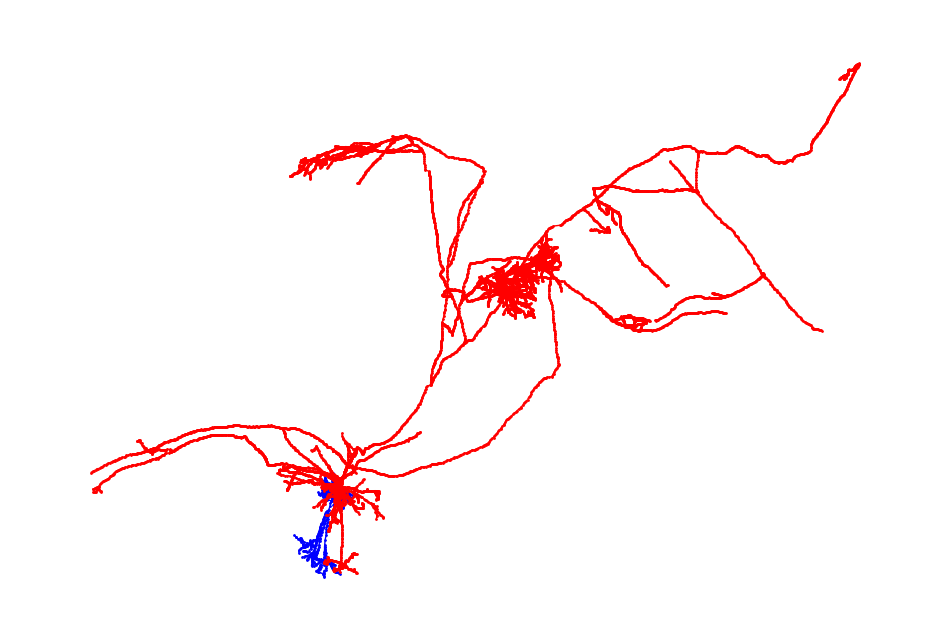

In [4]:
def plot_graph_2d(graph, ax, color="blue"):
    """
    Generate a 2D plot of a neuronal tree graph using matplotlib.

    Parameters:
    graph (nx.DiGraph): A directed graph representing the neuronal tree.
    """
    # Extracting node positions
    pos = {node: data['pos'][:2] for node, data in graph.nodes(data=True)}

    nx.draw(
        graph, 
        pos,
        ax=ax,
        arrows=False,
        width=1,
        with_labels=False, 
        node_size=1, 
        node_color=color,
        edge_color=color
    )
    
    
fig, ax = plt.subplots(figsize=(12, 8))

plot_graph_2d(dendrite, ax, "blue")
plot_graph_2d(axon, ax, "red")

plt.show()

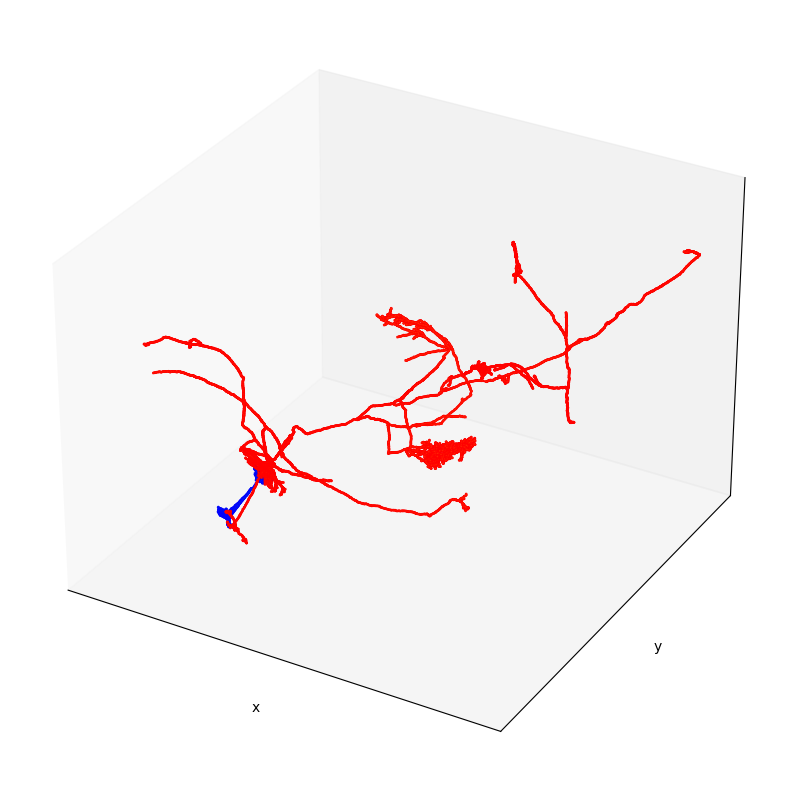

In [5]:
def plot_graph_3d(graph, ax, color='blue'):
    from mpl_toolkits.mplot3d import Axes3D

    pos = nx.get_node_attributes(graph, 'pos')
    
    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(graph)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in graph.edges()])

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, s=1, ec=color)

    # Plot the edges
    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color=color)

    def _format_axes(ax):
        """Visualization options for the 3D axes."""
        # Turn gridlines off
        ax.grid(False)
        # Suppress tick labels
        for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
            dim.set_ticks([])
        # Set axes labels
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")

    _format_axes(ax)
    
    
# Create the 3D figure
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="3d")

plot_graph_3d(dendrite, ax, "blue")
plot_graph_3d(axon, ax, "red")

fig.tight_layout()
plt.show()

### Morphological analysis

We introduce some new functions to analyze the trees

In [6]:
def find_branch_points(graph):
    """
    Identify all branch points in a graph. A branch point is defined as a node with more than one child.

    Parameters:
    graph (nx.Graph): The graph to analyze.

    Returns:
    list: A list of nodes that are branch points.
    """
    branch_points = [node for node in graph.nodes() if graph.out_degree(node) > 1]
    return branch_points

def find_terminals(graph):
    """
    Find all terminal nodes in a graph. A terminal node is defined as a node with no children.

    Parameters:
    graph (nx.Graph): The graph to analyze.

    Returns:
    list: A list of nodes that are terminal nodes.
    """
    terminal_nodes = [node for node in graph.nodes() if graph.out_degree(node) == 0]
    return terminal_nodes

def find_roots(graph):
    """
    Find the root nodes of a graph. A root node is defined as a node with no parent.

    Parameters:
    graph (nx.Graph): The graph to analyze.

    Returns:
    list: A list of root nodes.
    """
    roots = [node for node in graph.nodes() if graph.in_degree(node) == 0]
    return roots

def total_length(graph):
    """
    Calculate the total length of all edges in the graph.

    Parameters:
    graph (nx.Graph): The graph with weighted edges.

    Returns:
    float: Total length of all edges in the graph.
    """
    total_length = sum(weight for _, _, weight in graph.edges.data("weight"))
    return total_length

def bounding_box(graph):
    """
    Compute the bounding box of the XYZ coordinates of the graph nodes.

    Parameters:
    graph (nx.Graph): The graph with nodes containing XYZ coordinates.

    Returns:
    tuple: A tuple containing two tuples - the minimum and maximum XYZ coordinates.
           Format: ((min_x, min_y, min_z), (max_x, max_y, max_z))
    """
    # Initialize min and max coordinates with the first node's coordinates
    first_node = list(graph.nodes(data=True))[0][1]
    min_x, min_y, min_z = first_node['pos']
    max_x, max_y, max_z = first_node['pos']

    for _, attr in graph.nodes(data=True):
        x, y, z = attr['pos']
        min_x, min_y, min_z = min(min_x, x), min(min_y, y), min(min_z, z)
        max_x, max_y, max_z = max(max_x, x), max(max_y, y), max(max_z, z)

    return ((min_x, min_y, min_z), (max_x, max_y, max_z))

def get_depth(bounding_box):
    """
    Calculate the depth of the graph based on the bounding box.

    Parameters:
    bounding_box (tuple): Bounding box of the graph.

    Returns:
    float: Depth of the graph.
    """
    min_z, max_z = bounding_box[0][2], bounding_box[1][2]
    return max_z - min_z

def get_height(bounding_box):
    """
    Calculate the height of the graph based on the bounding box.

    Parameters:
    bounding_box (tuple): Bounding box of the graph.

    Returns:
    float: Height of the graph.
    """
    min_y, max_y = bounding_box[0][1], bounding_box[1][1]
    return max_y - min_y

def get_width(bounding_box):
    """
    Calculate the width of the graph based on the bounding box.

    Parameters:
    bounding_box (tuple): Bounding box of the graph.

    Returns:
    float: Width of the graph.
    """
    min_x, max_x = bounding_box[0][0], bounding_box[1][0]
    return max_x - min_x


def get_centroid(bounding_box):
    """
    Calculate the centroid of the graph based on the bounding box.

    Parameters:
    bounding_box (tuple): Bounding box of the graph.

    Returns:
    tuple: The centroid (x, y, z) of the graph.
    """
    min_coords, max_coords = bounding_box
    centroid = tuple((min_coords[i] + max_coords[i]) / 2 for i in range(3))
    return centroid


In [7]:
branch_points = find_branch_points(axon)
terminals = find_terminals(axon)
roots = find_roots(axon)
length = total_length(axon)

# Display the results
print("Axon Branch Points:", len(branch_points))
print("Axon Terminal Nodes:", len(terminals))
print("Axon Root:", len(roots))
print(f"Total Axon length: {length:.2f}um")

bbox = bounding_box(graph)
print(f"Bounding box dimensions: {bbox}")
print(f"Bounding box depth: {get_depth(bbox)}")
print(f"Bounding box width: {get_width(bbox)}")
print(f"Bounding box height: {get_height(bbox)}")
print(f"Bounding box centroid: {get_centroid(bbox)}")

Axon Branch Points: 382
Axon Terminal Nodes: 392
Axon Root: 1
Total Axon length: 98386.60um
Bounding box dimensions: ((2414.687321375, 1742.6953605, 1275.10017600001), (9319.1928203125, 6469.099084, 6266.113178))
Bounding box depth: 4991.01300199999
Bounding box width: 6904.5054989375
Bounding box height: 4726.4037235000005
Bounding box centroid: (5866.940070843751, 4105.897222250001, 3770.6066770000048)


## Finding inter-branch segments

Now let's try something a bit more interesting. We can decompose the tree into a collection of branches, where a "branch" satisfies one of the following conditions:
1) root -> (branch point or terminal)
3) branch point -> (branch point or terminal)

Then, we plot a histogram of branch lengths

In [8]:
def get_branches(graph):
    """
    Extract branches from the graph by tracing paths backwards from branch points and terminal nodes.

    Parameters:
    graph (nx.Graph): The graph from which to extract branches.

    Returns:
    list: A list of branches, where each branch is a list of tuples (u, v, edge_data).
          Each tuple represents an edge in the branch.
    """
    # Find all branch points and terminals
    relevant_nodes = find_branch_points(graph) + find_terminals(graph)

    branches = []
    for node in relevant_nodes:
        # Skip root nodes as they don't lead to a previous relevant node
        if graph.in_degree(node) == 0:
            continue

        path = []
        current = node
        # Walk back to the previous relevant node or root
        while graph.in_degree(current) > 0:
            parent = next(graph.predecessors(current))
            edge_data = graph.get_edge_data(parent, current)
            path.insert(0, (parent, current, edge_data))
            
            # Break the loop if a new branch point is reached
            if graph.out_degree(parent) > 1:
                break
            current = parent

        branches.append(path)

    return branches


def calculate_branch_length(branch):
    """
    Calculate the total length of a branch using the edge weights.

    Parameters:
    branch (list of tuples): Each tuple is an edge represented as (u, v, edge_data),
                             where edge_data is a dictionary containing the edge's weight.

    Returns:
    float: The total length of the branch.
    """
    total_length = 0.0
    for _, _, edge_data in branch:
        total_length += edge_data.get('weight', 0.0)  # Add the edge's weight, defaulting to 0 if not present

    return total_length


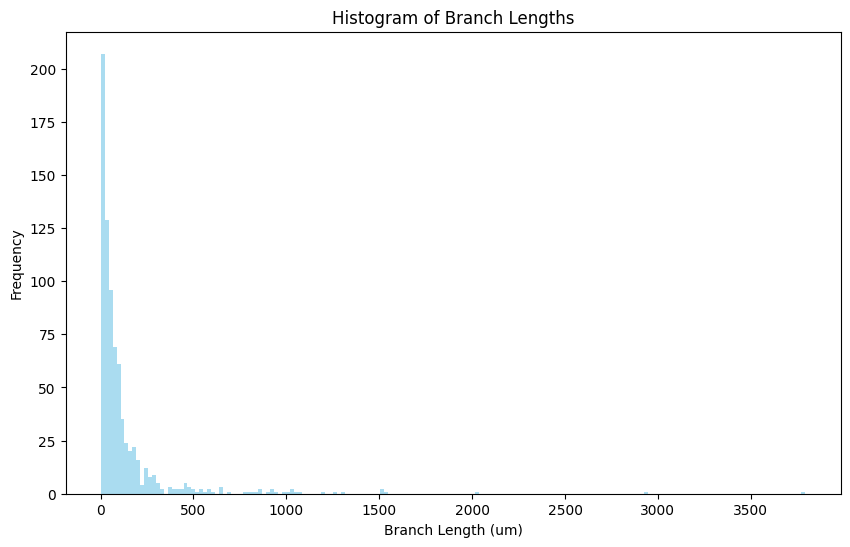

In [9]:
branches = get_branches(axon)

branch_lengths = [calculate_branch_length(branch) for branch in branches]

plt.figure(figsize=(10, 6))
plt.hist(branch_lengths, bins='auto', color='skyblue', alpha=0.7)
plt.title("Histogram of Branch Lengths")
plt.xlabel("Branch Length (um)")
plt.ylabel("Frequency")
plt.show()

## Computing the longest-shortest path

Let's find the [longest-shortest path](https://en.wikipedia.org/wiki/Longest_path_problem) in the graph.
NetworkX has a large suite of functions for computing shortest paths between vertices.
Since our graph is a DAG (directed acyclic graph, of which a tree is a special case), we can use `nx.dag_longest_path`, which runs in linear time.

In [10]:
longest_path = nx.dag_longest_path(graph, weight='weight')  # returns a list of nodes
longest_path_edges = list(zip(longest_path, longest_path[1:]))  # transform into list of edges
longest_path_length = sum(graph.get_edge_data(*e)['weight'] for e in longest_path_edges)  # calculate length
print("longest path from root to any terminal:", longest_path_length, "um") 

longest path from root to any terminal: 9771.961532068239 um


In [11]:
def plot_path_overlay(graph, path, path_color='red', graph_color='blue'):
    """
    Plot the graph with the longest path highlighted in a different color.

    Parameters:
    graph (nx.Graph): The graph to be visualized.
    path_color (str): Color for the longest path. Default is 'red'.
    graph_color (str): Color for the rest of the graph. Default is 'blue'.
    """

    # Create a set of all nodes in the longest path for easy checking
    path_nodes = set(path)
    path_edges = set(zip(path, path[1:]))

    # Draw the graph
    pos = {node: data['pos'][:2] for node, data in graph.nodes(data=True)}
    nx.draw(graph, pos, arrows=False, width=1, node_size=1, with_labels=False, node_color=graph_color, edge_color=graph_color)

    # Draw the longest path on top of the graph
    path_edge_colors = [path_color if (u, v) in path_edges or (v, u) in path_edges else graph_color for u, v in graph.edges()]
    nx.draw_networkx_nodes(graph, pos, nodelist=path_nodes, node_color=path_color, node_size=1)
    nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color=path_color, width=1, arrows=False)

    plt.show()


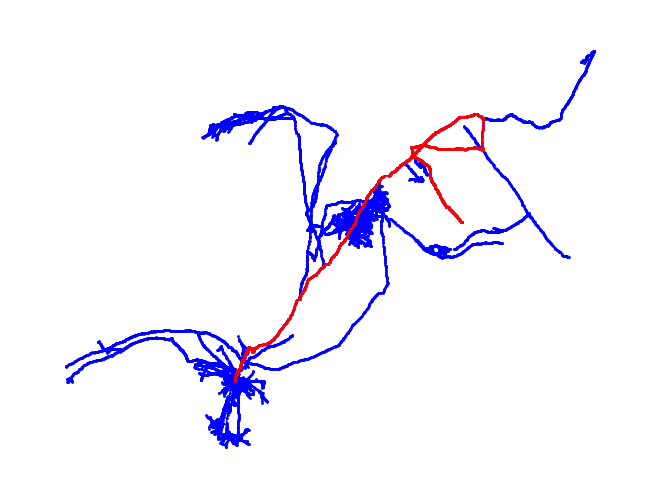

In [12]:
plot_path_overlay(graph, longest_path)

## Tracing the brain regions taken by the longest path

In [13]:
import pandas as pd

ccf_structures = pd.read_csv('/data/allen_mouse_ccf/annotation/adult_mouse_ccf_structures.csv')
ccf_structures.head()

,id,name,acronym,hemisphere_id,parent_structure_id,graph_order,structure_id_path,color_hex_triplet
0,1000,extrapyramidal fiber systems,eps,3,1009.0,1218,/997/1009/1000/,CCCCCC
1,223,Arcuate hypothalamic nucleus,ARH,3,157.0,733,/997/8/343/1129/1097/157/223/,FF5D50
2,12998,"Somatosensory areas, layer 6b",SS6b,3,453.0,36,/997/8/567/688/695/315/453/12998/,188064
3,163,"Agranular insular area, posterior part, layer 2/3",AIp2/3,3,111.0,287,/997/8/567/688/695/315/95/111/163/,219866
4,552,"Pontine reticular nucleus, ventral part",PRNv,3,987.0,914,/997/8/343/1065/771/987/552/,FFBA86


In [14]:
def get_adjusted_region_id(allen_id, ccf_structures, max_ccf_depth):
    """Get the adjusted region ID based on the CCF depth."""
    if allen_id is None:
        return None
    struct_path = ccf_structures[ccf_structures.id == allen_id].structure_id_path.values[0]
    struct_path = struct_path.strip('/').split('/')
    ccf_depth = len(struct_path) - 1
    if ccf_depth > max_ccf_depth:
        adjustment = max_ccf_depth - ccf_depth
        return int(struct_path[adjustment])
    return allen_id


def trace_longest_path_regions(longest_path, graph, ccf_structures, max_ccf_depth=7):
    """
    Trace the regions along the longest path in a graph, considering the CCF hierarchy.

    Parameters:
    longest_path (list): The longest path in the graph as a list of nodes.
    graph (nx.Graph): The graph representing the neuronal tree.
    ccf_structures (DataFrame): DataFrame containing CCF structure information.
    max_ccf_depth (int): Maximum depth in the CCF hierarchy to consider for regions.

    Returns:
    list: A list of unique region acronyms along the longest path without adjacent duplicates.
    """

    def remove_adjacent_duplicates(seq):
        """Remove adjacent duplicates from a sequence."""
        result = []
        prev = None
        for item in seq:
            if item != prev:
                result.append(item)
                prev = item
        return result

    # Construct the sequence of region acronyms along the longest path
    region_seq = []
    for node in longest_path:
        node_data = graph.nodes().data()[node]
        allen_id = node_data['allen_id']
        adjusted_id = get_adjusted_region_id(allen_id, ccf_structures, max_ccf_depth)
        acronym = ccf_structures[ccf_structures.id == adjusted_id].acronym.values[0]
        region_seq.append(acronym)

    # Remove adjacent duplicates and return the result
    return remove_adjacent_duplicates(region_seq)


In [15]:
print(" -> ".join(
    trace_longest_path_regions(
        longest_path, 
        graph, 
        ccf_structures,
        max_ccf_depth=6
    )
))

SSp -> MOp -> SSp -> MOp -> scwm -> ccb -> CP -> GPe -> PAL -> int -> GPi -> int -> cpd -> SNr -> MB -> HY -> ZI -> HY -> VM -> HY -> VM -> HY -> VM -> mtt -> SMT -> VM -> SMT -> VM -> TH -> RE -> TH -> RE -> TH -> VP


## Dimensionality Reduction 

Let's use these metrics to perform dimensionality reduction (PCA, UMAP) to explore underlying structure in the data.

In [16]:
def get_metrics(graph):
    """
    Calculate various metrics for a given neuronal tree graph.

    Parameters:
    graph (nx.Graph): The graph representing the neuronal tree.

    Returns:
    np.array: An array of calculated metrics
    """
    metrics = []

    # Check if there are any root nodes in the graph
    # root_nodes = find_roots(graph)
    # if not root_nodes:
    #     raise ValueError("Graph does not have any root nodes.")

    # # Soma location
    # soma = graph.nodes(data=True)[root_nodes[0]]
    # metrics.extend(soma['pos'])  # X, Y, Z coordinates of the soma

    # Basic graph metrics
    metrics.append(len(find_branch_points(graph)))
    metrics.append(len(find_terminals(graph)))
    metrics.append(total_length(graph))

    # Branch length metrics
    branch_lengths = np.array([calculate_branch_length(branch) for branch in get_branches(graph)])
    metrics.extend([branch_lengths.mean(), branch_lengths.std(), branch_lengths.max()])

    # Longest path length
    longest_path = nx.dag_longest_path(graph, weight='weight')
    longest_path_edges = zip(longest_path, longest_path[1:])
    longest_path_length = sum(graph.get_edge_data(*e)['weight'] for e in longest_path_edges)
    metrics.append(longest_path_length)

    # Bounding box metrics
    bbox = bounding_box(graph)  # Ensure to use compute_bounding_box function
    metrics.extend([get_depth(bbox), get_width(bbox), get_height(bbox)])
    
    # Centroid
    centroid = get_centroid(bbox)
    metrics.extend(centroid)  # X, Y, Z coordinates of the centroid

    return metrics


def all_graph_metrics(graphs):
    """
    Compile metrics for a collection of graphs into a single NumPy array.

    Parameters:
    graphs (list of nx.Graph): A list of graphs to compute metrics for.

    Returns:
    np.array, np.array: A 2D NumPy array where each row represents the metrics of a single graph, and a 1D numpy array of soma location IDs.
    """
    all_metrics = []
    soma_locations = []
    for graph in tqdm(graphs):
        try:
            soma_allen_id = graph.nodes()[find_roots(graph)[0]]['allen_id']
            if soma_allen_id is None:
                continue
            soma_locations.append(soma_allen_id)
            
            all_metrics.append(get_metrics(graph))

        except ValueError as e:
            print(f"Error in processing graph: {e}")
            continue

    return np.array(all_metrics), np.array(soma_locations)


def load_graphs(directory_path):
    """
    Load all JSON files in the given directory as graphs.

    Parameters:
    directory_path (str): Path to the directory containing JSON files.

    Returns:
    list of nx.Graph: A list of graphs loaded from the JSON files.
    """
    graphs = []
    for filename in tqdm(os.listdir(directory_path)):
        if filename.endswith(".json"):
            file_path = os.path.join(directory_path, filename)
            try:
                graph = json_to_digraph(file_path)
                graphs.append(graph)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
                continue

    return graphs


def filter_graphs_by_regions(graphs, target_regions, ccf_structures):
    """
    Filter a collection of graphs based on whether their soma region is within the target regions.

    Parameters:
    graphs (list of nx.Graph): A list of graphs, each representing a neuronal tree.
    target_regions (list): A list of target region identifiers to filter the graphs by.
    ccf_structures (pd.DataFrame): DataFrame of CCF structures

    Returns:
    list of nx.Graph: A list of graphs filtered based on the target regions.
    """
    filtered = []
    for graph in tqdm(graphs):
        soma_allen_id = graph.nodes()[find_roots(graph)[0]]['allen_id']
        if soma_allen_id is None:
            continue
        struct_path = ccf_structures[ccf_structures.id == soma_allen_id].structure_id_path.values[0]
        struct_path = struct_path.strip('/').split('/')
        if any(str(region) in struct_path for region in target_regions):
            filtered.append(graph)
    return filtered


In [17]:
json_dir = "../data/neuron_tracings/mouselight"
graphs = load_graphs(json_dir)

100%|██████████| 1549/1549 [08:28<00:00,  3.05it/s]


In [18]:
# Thalamus, MOs, ACA, hypothalamus, medulla, cerebellum, pons, striatum, hippocampus
graphs = filter_graphs_by_regions(graphs, [549, 993, 31, 1097, 354, 771, 512, 477, 1089], ccf_structures) 
print(len(graphs))

100%|██████████| 1549/1549 [00:06<00:00, 251.71it/s]

1204


In [19]:
X, Y = all_graph_metrics(graphs)

100%|██████████| 1204/1204 [01:24<00:00, 14.27it/s]


In [20]:
print(X)
print(Y)

[[1.31000000e+02 1.40000000e+02 5.31533214e+04 ... 3.73524763e+03
  2.50304671e+03 3.86709412e+03]
 [6.10000000e+02 6.17000000e+02 2.07444071e+05 ... 7.12025497e+03
  4.19641156e+03 7.42732425e+03]
 [4.52000000e+02 4.67000000e+02 1.41328488e+05 ... 8.02839622e+03
  5.38132075e+03 6.85088731e+03]
 ...
 [2.18000000e+02 2.27000000e+02 3.70332482e+04 ... 7.13417112e+03
  2.38123148e+03 2.91378122e+03]
 [2.52000000e+02 2.62000000e+02 6.39798134e+04 ... 6.94598278e+03
  2.50892632e+03 5.56520954e+03]
 [6.51000000e+02 6.58000000e+02 1.33301379e+05 ... 7.04012911e+03
  1.93122263e+03 6.55892520e+03]]
[ 767  767 1021 ...  733  382  382]


In [21]:
# Labels will be location of the soma at a maximum CCF depth (some regions might have lower depth)
max_ccf_depth = 3

Y_adjusted = [get_adjusted_region_id(allen_id, ccf_structures, max_ccf_depth) for allen_id in Y]

acronyms = [ccf_structures[ccf_structures.id == adjusted_id].acronym.values[0] for adjusted_id in Y_adjusted]

from collections import Counter
c = Counter(acronyms)
print(c)

Counter({'CTXpl': 648, 'TH': 201, 'MY': 110, 'HY': 92, 'P': 89, 'HEM': 31, 'STR': 17, 'VERM': 12, 'FN': 2, 'CB': 1, 'IP': 1})


In [22]:
from sklearn.preprocessing import StandardScaler

# remove mean and scale to unit variance
X = StandardScaler().fit_transform(X)
print(X)

[[-0.49695196 -0.48732836 -0.37536871 ... -1.46606664 -1.25473583
  -1.28494046]
 [ 1.04842886  1.03576802  1.86250346 ... -0.08639661  0.48008759
   1.0211897 ]
 [ 0.53867903  0.5568069   0.90354627 ...  0.28374595  1.69400685
   0.64780412]
 ...
 [-0.21626692 -0.20953091 -0.60917834 ... -0.08072463 -1.37953345
  -1.90244651]
 [-0.10657392 -0.09777331 -0.21833852 ... -0.15742692 -1.24871226
  -0.18499044]
 [ 1.18070571  1.16668406  0.78711905 ... -0.11905452 -1.84055984
   0.45868639]]


/tmp/ipykernel_80/3036701009.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_labels))


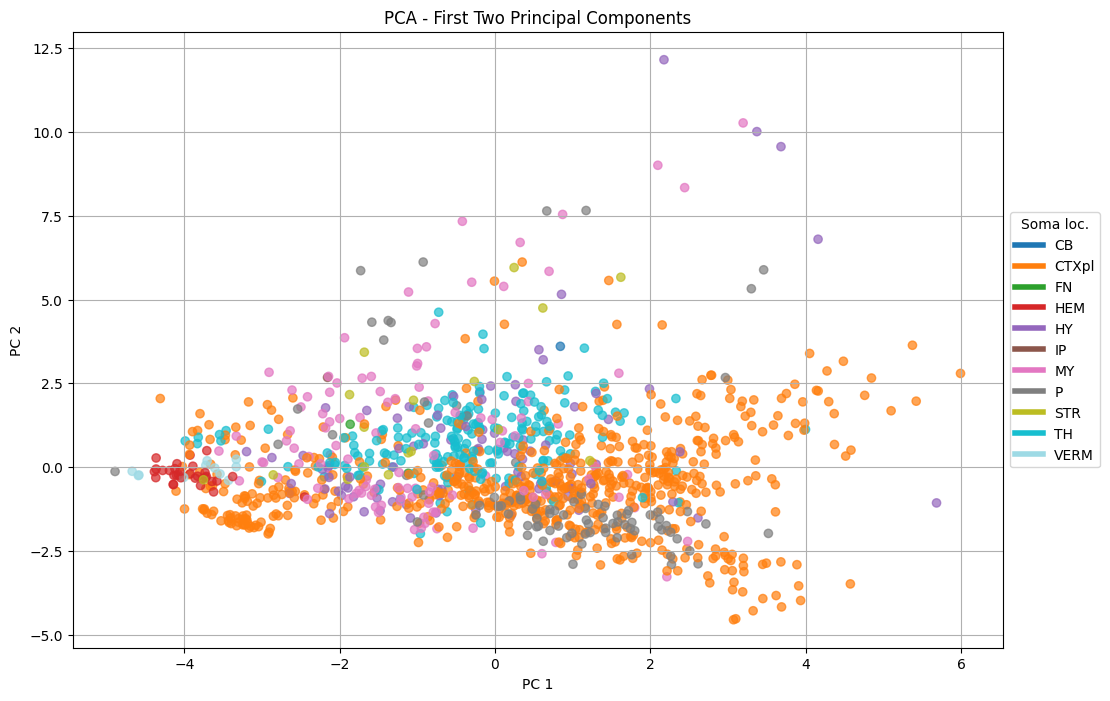

In [25]:
from sklearn.decomposition import PCA

def plot_pca(X, acronyms, n_components=2):
    p = PCA(n_components=n_components)
    transformed_data = p.fit_transform(X)

    # Map unique class labels to a range of integers
    unique_labels, label_indices = np.unique(acronyms, return_inverse=True)

    # Using a colormap that provides distinct colors
    cmap = plt.cm.get_cmap('tab20', len(unique_labels))

    # Plotting the first two principal components
    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = ax.scatter(transformed_data[:, 0], transformed_data[:, 1], c=label_indices, cmap=cmap, alpha=0.7)

    custom_legend = [plt.Line2D([0], [0], color=cmap(i), lw=4) for i in range(len(unique_labels))]
    ax.legend(custom_legend, unique_labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Soma loc.")
    
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_title('PCA - First Two Principal Components')
    ax.grid(True)
    plt.show()

plot_pca(X, acronyms)

/tmp/ipykernel_80/1610941463.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_labels))


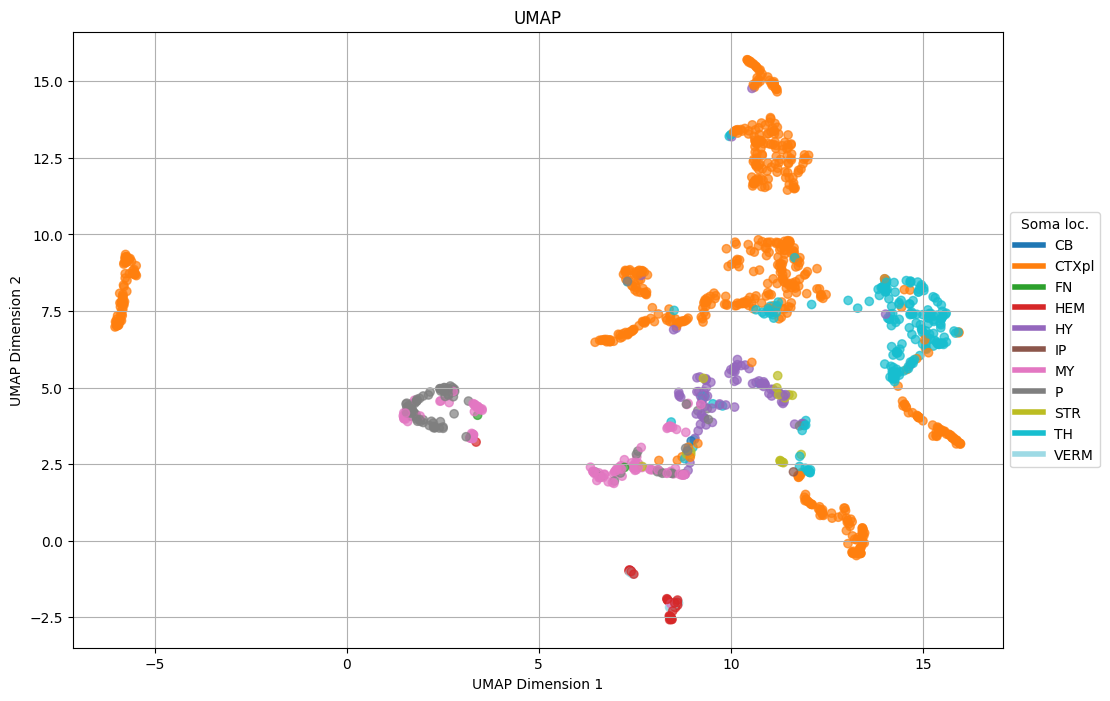

In [26]:
import umap

def plot_umap(X, acronyms, n_neighbors=10, min_dist=0.1, n_components=2):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    embedding = reducer.fit_transform(X)

    # Map unique class labels to a range of integers for coloring
    unique_labels, label_indices = np.unique(acronyms, return_inverse=True)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    cmap = plt.cm.get_cmap('tab20', len(unique_labels))
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=label_indices, cmap=cmap, alpha=0.7)

    custom_legend = [plt.Line2D([0], [0], color=cmap(i), lw=4) for i in range(len(unique_labels))]
    ax.legend(custom_legend, unique_labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Soma loc.")

    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    ax.set_title('UMAP')
    ax.grid(True)

    plt.show()


plot_umap(X, acronyms)